In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

2025-04-20 14:09:18.469570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745158158.645770      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745158158.696969      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print(f"Using {physical_devices[0].device_type} for training...")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

Using GPU for training...


# Helper Function for loading Videos and Alignments

In [3]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"\n(size ={char_to_num.vocabulary_size()})"
)

def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std  

def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' '] 
(size =28)


I0000 00:00:1745158176.186119      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Example Alignment: 
Text: [b'b' b'i' b'n' b' ' b'b' b'l' b'u' b'e' b' ' b'a' b't' b' ' b'f' b' '
 b't' b'h' b'r' b'e' b'e' b' ' b'p' b'l' b'e' b'a' b's' b'e']
Encoded:[ 2  9 14 27  2 12 21  5 27  1 20 27  6 27 20  8 18  5  5 27 16 12  5  1
 19  5]


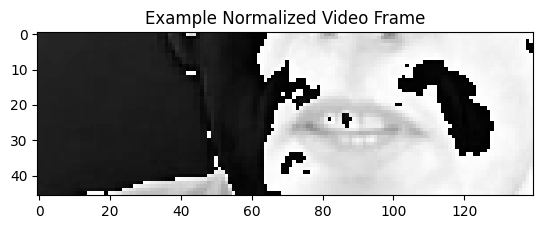

In [4]:
example_path = "/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s2_processed/"
ex_frame = load_video(os.path.join(example_path,"bbaf3p.mpg"))
plt.imshow(ex_frame[45], cmap = 'gray')
plt.title("Example Normalized Video Frame")

ex_alignment = load_alignments(os.path.join(example_path,'align',"bbaf3p.align"))
print(f"Example Alignment: \nText: {num_to_char(ex_alignment.numpy().astype(str))}"
      f"\nEncoded:{ex_alignment.numpy()}")

In [5]:
EXPECTED_FRAMES   = 75
EXPECTED_HEIGHT   = 46
EXPECTED_WIDTH    = 140
EXPECTED_CHANNELS = 1

def load_data(path):
    path = path.numpy().decode()
    file_name = os.path.splitext(os.path.basename(path))[0]
    base_dir       = '/kaggle/input/grid-corpus-dataset-for-training-lipnet/data'
    video_path     = os.path.join(base_dir, 's2_processed', f'{file_name}.mpg')
    alignment_path = os.path.join(base_dir, 's2_processed', 'align', f'{file_name}.align')

    try:
        frames     = load_video(video_path)       # → array of shape (T, H, W, C)
        alignments = load_alignments(alignment_path)
    except Exception as e:
        print(f"Skipping {file_name}.mpg due to load error: {e}")
        return (
            tf.random.normal((EXPECTED_FRAMES, EXPECTED_HEIGHT, EXPECTED_WIDTH, EXPECTED_CHANNELS), 
                     dtype=tf.dtypes.float32),
            tf.convert_to_tensor([], dtype=tf.dtypes.int64)
        )

    if (frames.shape[0]   == EXPECTED_FRAMES and
        frames.shape[1:] == (EXPECTED_HEIGHT, EXPECTED_WIDTH, EXPECTED_CHANNELS) and
        len(alignments)  > 0):
        return frames, alignments
    else:
        print(f"Skipping {file_name}.mpg due to shape mismatch: "
              f"frames.shape={frames.shape}, align_len={len(alignments)}")
        return (
            tf.random.normal((EXPECTED_FRAMES, EXPECTED_HEIGHT, EXPECTED_WIDTH, EXPECTED_CHANNELS), 
                     dtype=tf.dtypes.float32),
            tf.convert_to_tensor([], dtype=tf.dtypes.int64)
        )

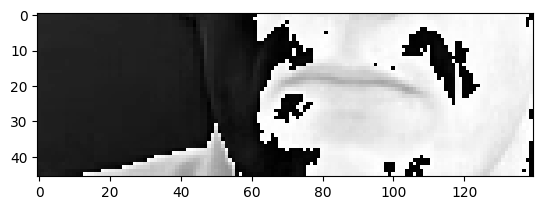

In [6]:
test_path = '/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s2_processed/bbaf2s.mpg'
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]
frames, alignments = load_data(tf.convert_to_tensor(test_path))
plt.imshow(frames[70], cmap = 'gray')

In [7]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Data Pipeline

In [38]:
data = tf.data.Dataset.list_files('/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s2_processed/*.mpg')
AUTOTUNE = tf.data.AUTOTUNE
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(AUTOTUNE)
# Data split 
train = data.take(300)
val = data.skip(300).take(150)
test = data.skip(450)

In [9]:
print(f"Training Dataset Size: {len(train)}"
     f"\nValidation Dataset Size: {len(val)}"
    f"\nTest Dataset Size: {len(test)}")

Training Dataset Size: 300
Validation Dataset Size: 150
Test Dataset Size: 50


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv3D,
    Activation,
    MaxPool3D,
    SpatialDropout3D,
    Reshape,
    Bidirectional,
    GRU,
    LSTM,
    Dropout,
    Dense
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import load_model


# LipNet Architecture

In [15]:
def build_lipnet_model(input_shape:tuple[int, ...] = None, dropout_rate:float = 0.5):
    EXPECTED_FRAMES, EXPECTED_HEIGHT, EXPECTED_WIDTH, EXPECTED_CHANNELS = input_shape
    model = Sequential()
    model.add(Input(shape=(EXPECTED_FRAMES, EXPECTED_HEIGHT, EXPECTED_WIDTH, EXPECTED_CHANNELS)))
    
    # Spatiotemporal Conv Block 1
    model.add(Conv3D(128, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))
    
    # Spatiotemporal Conv Block 2
    model.add(Conv3D(256, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))
    
    # Spatiotemporal Conv Block 3
    model.add(Conv3D(75, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))
    
    # Flatten per time-step
    model.add(Reshape((EXPECTED_FRAMES, -1)))
    
    # Recurrent layers (2× Bi-GRU)
    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(dropout_rate))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(dropout_rate))

    # Classification layer
    model.add(Dense(
        units=char_to_num.vocabulary_size() + 1,
        activation='softmax',
        kernel_initializer='he_normal'
        ))

    return model

In [17]:
raw_model = build_lipnet_model(input_shape = (75, 46, 140, 1),
                               dropout_rate = 0.5)

# Initial Prediction before Training
frames, alignments = data.as_numpy_iterator().next()
sample = data.as_numpy_iterator()
val = sample.next()
yhat = raw_model.predict(val[0])
print(f"Model's Output Before Training: {tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])}")

print(raw_model.summary())

I0000 00:00:1745158220.739532      88 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Model's Output Before Training: b'innnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnmmmmmmmmmm'


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)                    │ (None, 75, 46, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 75, 46, 140, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 75, 23, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_4 (Conv3D)                    │ (None, 75, 23, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 75, 23, 70, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 75, 11, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 75, 11, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 75, 11, 35, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 75, 5, 17, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 75, 6375)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 75, 256)             │       6,660,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 75, 29)              │           7,453 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,468,840 (32.31 MB)

 Trainable params: 8,468,840 (32.31 MB)

 Non-trainable params: 0 (0.00 B)

None


## CTCLoss Function

In [18]:
from tensorflow.keras.utils import register_keras_serializable
@register_keras_serializable(package='CustomLosses')
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

## Callbacks

In [19]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('-+'*50)

In [20]:
checkpoint_dir = '/kaggle/working/trained_model/'
checkpoint_path = (
    checkpoint_dir
    + 'lipnet.keras'
)

os.makedirs(checkpoint_dir, exist_ok = True)

model_checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',       
    verbose=1,                 
    save_best_only=True,       
    mode='min',                
    save_weights_only=False
)

example_callback = ProduceExample(test)

In [ ]:
EPOCHS = 50
DROPOUT_RATE = 0.5
LEARNING_RATE = 1e-4
BASE_DIR = "/kaggle/working"
saved_model_path = os.path.join(BASE_DIR, 'trained_model','lipnet.keras')
use_existing_model = False # To indicate whether to use a existing trained model for further training or use a new model

if os.path.exists(saved_model_path) and use_existing_model:
    try:
        model = tf.keras.models.load_model(saved_model_path)
        print(f"Existing model at {saved_model_path} loaded successfully:)")
    except Exception as e:
        print(f"Model Found but can't be loaded due to following error:("
             f"\n{e}")
    else:
        try:
            print("Starting training on the loaded model...")
            history = model.fit(train, 
                      epochs=EPOCHS, 
                      callbacks=[model_checkpoint_cb, example_callback],
                      validation_data = val)
        except Exception as e:
            print(f"Loaded model training failed due to the following error:("
                  f"\n{e}")

else:
    print("Training new model instance...")
    model = build_lipnet_model(input_shape = (75, 46, 140, 1), dropout_rate = 0.5)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE, weight_decay = 1e-4), loss=CTCLoss)
    history = model.fit(train, 
                      epochs=EPOCHS, 
                      callbacks=[model_checkpoint_cb, example_callback],
                      validation_data = val)
    print(f"\n---------Training Completed:)")

Training new model instance...
Epoch 1/50


I0000 00:00:1745158241.427077      88 service.cc:148] XLA service 0x42d71ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745158241.427521      88 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745158241.925234      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - loss: 98.7403
Epoch 1: val_loss improved from inf to 64.92174, saving model to /kaggle/working/trained_model/lipnet.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
Original: set blue in m seven now
Prediction: le e e e e o
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Original: place red in v four soon
Prediction: le e e e e o
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
300/300 ━━━━━━━━━━━━━━━━━━━━ 424s 1s/step - loss: 98.6938 - val_loss: 64.9217
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - loss: 72.6303
Epoch 2: val_loss improved from 64.92174 to 64.60866, saving model to /kaggle/working/trained_model/lipnet.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Original: bin white by a three now
Prediction: la e e e e on
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Original: s

# Training & Validation loss curves

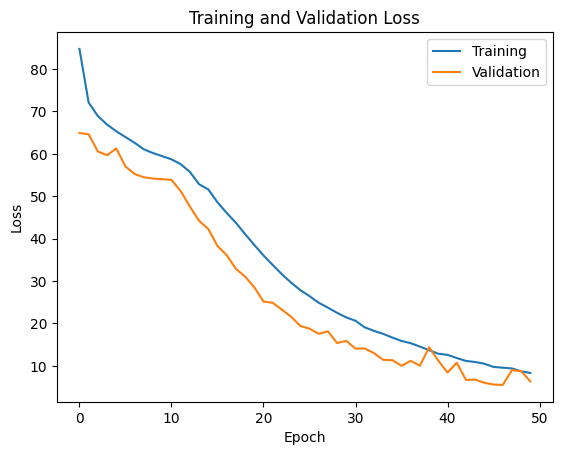

In [23]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig("/kaggle/working/epoch50_train_val_loss_curves.png", dpi = 500)
plt.show()

# Model Evaluation

In [24]:
from tensorflow.keras import backend as K

model = load_model('/kaggle/working/trained_model/lipnet.keras')
print("Model Loaded Successfully:)")

print("Making Predictions for Test Dataset...")
y_pred = model.predict(test)
print("Prediction made Successfully:)")

Model Loaded Successfully:)
Making Predictions for Test Dataset...
50/50 ━━━━━━━━━━━━━━━━━━━━ 217s 508ms/step
Prediction made Successfully:)


In [48]:
VIDEO_DIR = '/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s2_processed'
ALIGN_DIR = os.path.join(VIDEO_DIR, 'align')

# 1. Sample 10 random unseen speaker video files
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith('.mpg')]
sample_files = random.sample(video_files, 10)

# 2. Load videos and true alignments
videos = []
true_aligns = []
for fname in sample_files:
    vid = load_video(os.path.join(VIDEO_DIR, fname))
    aligns = load_alignments(os.path.join(ALIGN_DIR, fname.replace('.mpg', '.align')))
    videos.append(vid)
    true_aligns.append(aligns)

# 3. Batch into a NumPy array
X = np.stack(videos, axis=0)  # shape: (5, 75, 46, 140, 1)

# 4. Predict logits and CTC-decode
logits = model.predict(X)
input_lengths = np.ones((len(videos),), dtype=np.int32) * logits.shape[1]
decoded, _ = K.ctc_decode(logits, input_length=input_lengths, greedy=True)
decoded_seq = decoded[0].numpy()  # shape: (5, timesteps)


def tokens_to_text(token_seq):
    chars = num_to_char(tf.constant(token_seq)).numpy().astype(str)
    return ''.join([c for c in chars if c != ''])

# 6. Convert predictions and true labels to text
pred_texts = [tokens_to_text(seq) for seq in decoded_seq]
# If true_aligns are integer lists:
true_texts = [tokens_to_text(align) for align in true_aligns]

# 7. Display results
for fname, true_t, pred_t in zip(sample_files, true_texts, pred_texts):
    print(f"File: {fname}")
    print("  True : ", true_t)
    print("  Pred : ", pred_t)
    print("-" * 50)

cer_list = []
wer_list = []
exact_matches = 0

for true, pred in zip(true_texts, pred_texts):
    if true == pred:
        exact_matches += 1

    # Character Error Rate (CER)
    cer_dist = edit_distance(list(true), list(pred))
    cer = cer_dist / max(1, len(true))
    cer_list.append(cer)
    
    # Word Error Rate (WER)
    true_words = true.split()
    pred_words = pred.split()
    wer_dist = edit_distance(true_words, pred_words)
    wer = wer_dist / max(1, len(true_words))
    wer_list.append(wer)

avg_cer = np.mean(cer_list)
avg_wer = np.mean(wer_list)
sentence_accuracy = exact_matches / len(y_true_text)

print(f"Average CER: {avg_cer:.4f}")
print(f"Average WER: {avg_wer:.4f}")
print(f"Sentence-level accuracy: {sentence_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
File: pwwrza.mpg
  True :  place white with r zero again
  Pred :  place white with zero again
--------------------------------------------------
File: srih1p.mpg
  True :  set red in h one please
  Pred :  set red in one please
--------------------------------------------------
File: sgav5p.mpg
  True :  set green at v five please
  Pred :  set green at five please
--------------------------------------------------
File: prii6s.mpg
  True :  place red in i six soon
  Pred :  place red i six soon
--------------------------------------------------
File: lgas4a.mpg
  True :  lay green at s four again
  Pred :  lay green at four again
--------------------------------------------------
File: pbav1n.mpg
  True :  place blue at v one now
  Pred :  place blue at one now
--------------------------------------------------
File: lgbs6s.mpg
  True :  lay green by s six soon
  Pred :  lay green by six soon
--------------------------------------------------
Fi